In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("mnist/", one_hot=True)
num_train=mnist.train.num_examples
num_val=mnist.validation.num_examples
num_test=mnist.test.num_examples

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [3]:
# predefined parameters
channel=1
height=28
width=28
patch=7
n_glimpse=15
lstm_hidden_dim=256
latent_dim=512
eps=1e-10

In [4]:
tf.reset_default_graph()


def decode_attention_para(hidden_decode,paser):
    '''
    calculate parameters(gx,gy,sigma,stride,gamma) from h_dec
    each is (batch,1) tensor
    '''
    paras=paser(hidden_decode)
    gx,gy,sigma,stride,gamma=tf.split(paras,[1,1,1,1,1],axis=1)
    gx=(gx+1.0)*(width+1)/2.0
    gy=(gy+1.0)*(height+1)/2.0
    sigma=tf.exp(sigma)
    stride=tf.exp(stride)*(max(width,height)-1.0)/(patch-1.0)
    gamma=tf.exp(gamma)
    return gx,gy,sigma,stride,gamma


def filterbank(batch_size,gx,gy,sigma,stride):
    '''
    calculate filterbank FX and FY using parameters
    shape of FX is (batch,channel,patch,width), each tensor in axis=3 is gaussian distribution centered at gx and scale is sigma
    shape of FY is (batch,channel,patch,height), similar to FX
    '''
    # initialize FY, shape=(batch,patch,height), value is multipling range(height) for (batch*patch) times
    FY=tf.tile(tf.reshape(tf.range(height,dtype=tf.float32),(1,1,height)),multiples=(batch_size,patch,1))
    # center position, shape=(batch,patch), value is like (-2stride+gy,-stride+gy,gy,stride+gy,2stride+gy) for all batches
    py=tf.tile(tf.reshape(tf.range(patch,dtype=tf.float32)-(patch-1)//2,(1,patch)),multiples=(batch_size,1))*stride+gy
    # gaussian distribution of FY, shape is the same as FY, value is gaussian for all batches
    FY=tf.exp(-tf.square(FY-tf.reshape(py,(-1,patch,1)))/2.0*tf.reshape(sigma,(-1,1,1)))   # modified
    # normalized FY, shape=(batch,patch,height), each vector is sumed to 1
    FY/=(eps+tf.reduce_sum(FY,axis=2,keep_dims=True))   # modified: add eps for numerical stability
    # copy through all channels, shape=(batch,channel,patch,height)
    FY=tf.tile(tf.reshape(FY,[-1,1,patch,height]),(1,channel,1,1))
    
    FX=tf.tile(tf.reshape(tf.range(width,dtype=tf.float32),(1,1,width)),multiples=(batch_size,patch,1))
    px=tf.tile(tf.reshape(tf.range(patch,dtype=tf.float32)-(patch-1)//2,(1,patch)),multiples=(batch_size,1))*stride+gx
    FX=tf.exp(-tf.square(FX-tf.reshape(px,(-1,patch,1)))/2.0*tf.reshape(sigma,(-1,1,1)))   # modified
    FX/=(eps+tf.reduce_sum(FX,axis=2,keep_dims=True))   # modified
    FX=tf.tile(tf.reshape(FX,[-1,1,patch,width]),(1,channel,1,1))
    return FX,FY

def read(image,FX,FY,gamma):
    '''
    Inputs:
    image, shape=(batch,channel,height,width)
    filterbank FX, shape=(batch,channel,patch,width)
    filterbank FY, shape=(batch,channel,patch,height)
    scale intensity gamma, shape=(batch,1)
    
    Outputs:
    encoded patch, shape=(batch,channel*patch*patch)
    '''
    patch_image=tf.matmul(tf.matmul(FY,X),FX,transpose_b=True)*tf.reshape(gamma,(-1,1,1,1))
    patch_image=tf.layers.flatten(patch_image)
    return patch_image
    
def write(pat,batch_size,FX,FY,gamma):
    '''
    Inputs:
    pat, patch decode from hidden, shape=(batch,channel*patch*patch)
    filterbank FX, shape=(batch,channel,patch,width)
    filterbank FY, shape=(batch,channel,patch,height)
    scale intensity gamma, shape=(batch,1)
    
    Outputs:
    decoded image, shape=(batch,channel,height,width)
    '''
    pat=tf.reshape(pat,(batch_size,channel,patch,patch))
    reconstruct_image=tf.matmul(tf.matmul(FY,pat,transpose_a=True),FX)/tf.reshape(gamma,(-1,1,1,1))
    return reconstruct_image

def logistic_likelihood(original_image,recon_image):
    return -(original_image*tf.log(eps+recon_image)+(1.0-original_image)*tf.log(1.0-recon_image))


# input
X=tf.placeholder(shape=[None,channel,height,width],dtype=tf.float32,name='input_image')
batch_size=tf.shape(X)[0]
canvas=tf.zeros(shape=[batch_size,channel,height,width],dtype=tf.float32,name='output_canvas')

READ_attention_paras=tf.layers.Dense(units=5,name='attention_para_read')   # calculate parameters for READ operation
WRITE_attention_paras=tf.layers.Dense(units=5,name='attention_para_write')   # calculate parameters for WRITE operation
WRITE_patch=tf.layers.Dense(units=channel*patch*patch,name='patch_write')   # calculate patch_image for WRITE operation
encoder_lstm=tf.contrib.rnn.LSTMCell(lstm_hidden_dim)
decoder_lstm=tf.contrib.rnn.LSTMCell(lstm_hidden_dim)
init_state_encode=encoder_lstm.zero_state(batch_size, tf.float32)   # lstm tuple (c,h)
init_state_decode=decoder_lstm.zero_state(batch_size, tf.float32)   # lstm tuple (c,h)
state_encode=None
state_decode=None
encoder_mean=tf.layers.Dense(units=latent_dim,name='encoder_mean')   # calculate mean of z
encoder_std=tf.layers.Dense(units=latent_dim,name='encoder_std')   # calculate std of z
unit_gaussian=tf.distributions.Normal(loc=tf.zeros(latent_dim),scale=tf.ones(latent_dim),name='unit_norm')

read_paras_his=[]
write_paras_his=[]
canvas_his=[]
latent_loss_his=[]
likelihood_loss_his=[]

for t in range(n_glimpse):
    error_image=X-canvas
    previous_hidden_decode=init_state_decode[1] if t==0 else state_decode[1]
    gx,gy,sigma,stride,gamma=decode_attention_para(previous_hidden_decode,READ_attention_paras)
    read_paras_his.append((gx,gy,stride,sigma))
    FX,FY=filterbank(batch_size,gx,gy,sigma,stride)
    patch_image=read(X,FX,FY,gamma)
    patch_error_image=read(error_image,FX,FY,gamma)
    encoder_input=tf.concat([patch_image,patch_error_image,previous_hidden_decode],axis=1)
    with tf.variable_scope("LSTM_encoder") as vs:
        encoder_out,state_encode=encoder_lstm(encoder_input,init_state_encode if t==0 else state_encode)
    z_mean=encoder_mean(encoder_out)
    z_std=tf.exp(encoder_std(encoder_out))
    distrib_encode=tf.distributions.Normal(loc=z_mean,scale=z_std)
    Z=distrib_encode.sample()
    
    latent_loss=tf.reduce_sum(tf.distributions.kl_divergence(distrib_encode,unit_gaussian),axis=1)
    latent_loss_his.append(latent_loss)
    
    with tf.variable_scope("LSTM_decoder") as vs:
        decoder_out,state_decode=decoder_lstm(Z,init_state_decode if t==0 else state_decode)
    _gx,_gy,_sigma,_stride,_gamma=decode_attention_para(decoder_out,WRITE_attention_paras)
    write_paras_his.append((_gx,_gy,_stride,_sigma))
    new_patch_image=WRITE_patch(decoder_out)
    _FX,_FY=filterbank(batch_size,_gx,_gy,_sigma,_stride)
    added_image=write(new_patch_image,batch_size,_FX,_FY,_gamma)
    canvas+=added_image
    
    canvas_his.append(canvas)
    
total_latent_loss=tf.reduce_mean(latent_loss_his)
total_likelihood_loss=tf.reduce_mean(tf.reduce_sum(tf.square(tf.layers.flatten(X)-tf.layers.flatten(canvas)),axis=1))
total_loss=total_latent_loss+total_likelihood_loss

global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 1e-3
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,num_train//128, 0.9, staircase=True)
optimizier=tf.train.RMSPropOptimizer(learning_rate=starter_learning_rate)
# train_step = optimizier.minimize(total_loss,global_step=global_step)
train_step = optimizier.minimize(total_loss)

In [5]:
batch_size=128
max_epoch=100
print_every=50
num_iteration=num_train//batch_size
loss_train_his=[]
loss_val_his=[]
loss_test_his=[]

def eval(dataset,num_iteration):
    t_loss=0
    for it in range(num_iteration):
        images,labels=dataset.next_batch(batch_size)
        loss_num = sess.run(total_loss,feed_dict={X:images.reshape((-1,1,28,28))})
        t_loss+=loss_num
    t_loss/=num_iteration
    return t_loss

saver=tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(max_epoch):
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                  'start epoch %d/%d, with learning rate = %.10f' % (epoch+1,max_epoch,sess.run(learning_rate)))
        average_loss=0
        average_loss1=0
        average_loss2=0
        for it in range(num_iteration):
            images,labels=mnist.train.next_batch(batch_size)
            feed_dict={X:images.reshape((-1,1,28,28))}
#             loss_num,l1,l2,temp1,temp2,_=sess.run([total_loss,total_latent_loss,total_likelihood_loss,X,canvas,train_step],feed_dict=feed_dict)
            loss_num,l1,l2,_=sess.run([total_loss,total_latent_loss,total_likelihood_loss,train_step],feed_dict=feed_dict)
            if it==0 or (it+1)%print_every==0 or it==num_iteration-1:
                print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                      'iteration %d/%d:' % (it+1,num_iteration),'current training loss = %f (=%f+%f)' % (loss_num,l1,l2))
        
        loss_train=eval(mnist.train,num_train//batch_size)
        loss_val=eval(mnist.validation,num_val//batch_size)
        loss_test=eval(mnist.test,num_test//batch_size)
        loss_train_his.append(loss_train)
        loss_val_his.append(loss_val)
        loss_test_his.append(loss_test)
        
        save_path = saver.save(sess, "parameters/DRAW/DRAW.ckpt")
        print("model saved in path: %s" % save_path)
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'end epoch %d/%d:' % (epoch+1,max_epoch),
                 'loss_train=%f loss_val=%f loss_test=%f' % (loss_train,loss_val,loss_test))
        print()

2018-05-08 14:09:06 start epoch 1/100, with learning rate = 0.0010000000
2018-05-08 14:09:10 iteration 1/429: current training loss = 99.822807 (=3.446402+96.376404)
2018-05-08 14:09:16 iteration 50/429: current training loss = 64.820816 (=2.465810+62.355007)
2018-05-08 14:09:22 iteration 100/429: current training loss = 54.419647 (=1.494701+52.924946)
2018-05-08 14:09:27 iteration 150/429: current training loss = 46.476341 (=1.601865+44.874477)
2018-05-08 14:09:32 iteration 200/429: current training loss = 43.925968 (=1.987376+41.938591)
2018-05-08 14:09:37 iteration 250/429: current training loss = 40.956562 (=2.275151+38.681412)
2018-05-08 14:09:43 iteration 300/429: current training loss = 33.976704 (=2.343101+31.633602)
2018-05-08 14:09:48 iteration 350/429: current training loss = 32.114933 (=2.520636+29.594297)
2018-05-08 14:09:53 iteration 400/429: current training loss = 32.709564 (=2.688544+30.021019)
2018-05-08 14:09:56 iteration 429/429: current training loss = 30.096266 (=

2018-05-08 14:16:50 iteration 50/429: current training loss = 16.406328 (=3.873509+12.532819)
2018-05-08 14:16:56 iteration 100/429: current training loss = 14.167481 (=3.674333+10.493149)
2018-05-08 14:17:01 iteration 150/429: current training loss = 15.257262 (=3.980789+11.276473)
2018-05-08 14:17:07 iteration 200/429: current training loss = 15.611237 (=3.877922+11.733315)
2018-05-08 14:17:12 iteration 250/429: current training loss = 15.758858 (=3.854396+11.904462)
2018-05-08 14:17:17 iteration 300/429: current training loss = 15.870102 (=3.834571+12.035531)
2018-05-08 14:17:23 iteration 350/429: current training loss = 15.079950 (=3.760809+11.319141)
2018-05-08 14:17:28 iteration 400/429: current training loss = 14.356388 (=3.627188+10.729200)
2018-05-08 14:17:31 iteration 429/429: current training loss = 15.178232 (=3.896314+11.281918)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-08 14:17:48 end epoch 8/100: loss_train=14.700144 loss_val=14.530088 loss_test=14.545388

2

2018-05-08 14:24:25 iteration 100/429: current training loss = 12.148516 (=3.575399+8.573116)
2018-05-08 14:24:30 iteration 150/429: current training loss = 12.658076 (=3.602327+9.055750)
2018-05-08 14:24:35 iteration 200/429: current training loss = 12.509583 (=3.792895+8.716688)
2018-05-08 14:24:40 iteration 250/429: current training loss = 12.670876 (=3.562409+9.108467)
2018-05-08 14:24:45 iteration 300/429: current training loss = 12.390611 (=3.473392+8.917218)
2018-05-08 14:24:50 iteration 350/429: current training loss = 12.456467 (=3.619895+8.836572)
2018-05-08 14:24:56 iteration 400/429: current training loss = 12.390902 (=3.725344+8.665557)
2018-05-08 14:24:59 iteration 429/429: current training loss = 12.131765 (=3.647515+8.484250)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-08 14:25:16 end epoch 15/100: loss_train=12.080613 loss_val=11.901157 loss_test=11.986913

2018-05-08 14:25:16 start epoch 16/100, with learning rate = 0.0010000000
2018-05-08 14:25:16 iteratio

2018-05-08 14:31:50 iteration 150/429: current training loss = 10.924980 (=3.440863+7.484118)
2018-05-08 14:31:55 iteration 200/429: current training loss = 11.255090 (=3.369261+7.885829)
2018-05-08 14:32:00 iteration 250/429: current training loss = 10.923490 (=3.371068+7.552422)
2018-05-08 14:32:05 iteration 300/429: current training loss = 10.924568 (=3.424950+7.499618)
2018-05-08 14:32:11 iteration 350/429: current training loss = 10.302245 (=3.251194+7.051051)
2018-05-08 14:32:16 iteration 400/429: current training loss = 11.221402 (=3.467097+7.754306)
2018-05-08 14:32:19 iteration 429/429: current training loss = 11.129930 (=3.416262+7.713668)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-08 14:32:36 end epoch 22/100: loss_train=10.928938 loss_val=10.831451 loss_test=10.834476

2018-05-08 14:32:36 start epoch 23/100, with learning rate = 0.0010000000
2018-05-08 14:32:36 iteration 1/429: current training loss = 11.255434 (=3.515235+7.740199)
2018-05-08 14:32:42 iteration 

2018-05-08 14:39:28 iteration 250/429: current training loss = 10.311943 (=3.288332+7.023611)
2018-05-08 14:39:33 iteration 300/429: current training loss = 10.622517 (=3.320654+7.301863)
2018-05-08 14:39:38 iteration 350/429: current training loss = 10.546897 (=3.489356+7.057541)
2018-05-08 14:39:44 iteration 400/429: current training loss = 10.484878 (=3.418944+7.065934)
2018-05-08 14:39:47 iteration 429/429: current training loss = 10.246481 (=3.318757+6.927724)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-08 14:40:04 end epoch 29/100: loss_train=9.885125 loss_val=9.782084 loss_test=9.843714

2018-05-08 14:40:04 start epoch 30/100, with learning rate = 0.0010000000
2018-05-08 14:40:04 iteration 1/429: current training loss = 9.651613 (=3.224042+6.427570)
2018-05-08 14:40:10 iteration 50/429: current training loss = 11.404932 (=3.291097+8.113834)
2018-05-08 14:40:15 iteration 100/429: current training loss = 10.105448 (=3.172786+6.932662)
2018-05-08 14:40:20 iteration 150/4

2018-05-08 14:47:00 iteration 350/429: current training loss = 10.123198 (=3.169740+6.953457)
2018-05-08 14:47:05 iteration 400/429: current training loss = 9.813866 (=3.160824+6.653042)
2018-05-08 14:47:08 iteration 429/429: current training loss = 10.183477 (=3.335296+6.848181)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-08 14:47:24 end epoch 36/100: loss_train=9.952242 loss_val=9.919503 loss_test=9.862512

2018-05-08 14:47:24 start epoch 37/100, with learning rate = 0.0010000000
2018-05-08 14:47:24 iteration 1/429: current training loss = 10.140847 (=3.265924+6.874924)
2018-05-08 14:47:30 iteration 50/429: current training loss = 9.468438 (=3.239798+6.228640)
2018-05-08 14:47:35 iteration 100/429: current training loss = 9.978903 (=3.347355+6.631548)
2018-05-08 14:47:41 iteration 150/429: current training loss = 9.805079 (=3.205887+6.599191)
2018-05-08 14:47:47 iteration 200/429: current training loss = 9.480090 (=3.240392+6.239698)
2018-05-08 14:47:52 iteration 250/429: 

2018-05-08 14:54:35 iteration 429/429: current training loss = 9.051932 (=3.113802+5.938130)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-08 14:54:52 end epoch 43/100: loss_train=9.469177 loss_val=9.486582 loss_test=9.427295

2018-05-08 14:54:52 start epoch 44/100, with learning rate = 0.0010000000
2018-05-08 14:54:52 iteration 1/429: current training loss = 9.771257 (=3.242299+6.528959)
2018-05-08 14:54:58 iteration 50/429: current training loss = 9.006730 (=3.197778+5.808952)
2018-05-08 14:55:03 iteration 100/429: current training loss = 8.658525 (=3.103809+5.554716)
2018-05-08 14:55:08 iteration 150/429: current training loss = 9.129074 (=3.179327+5.949747)
2018-05-08 14:55:13 iteration 200/429: current training loss = 9.096211 (=3.158684+5.937528)
2018-05-08 14:55:19 iteration 250/429: current training loss = 9.333291 (=3.148308+6.184983)
2018-05-08 14:55:24 iteration 300/429: current training loss = 9.379913 (=3.179743+6.200171)
2018-05-08 14:55:29 iteration 350/429: cur

2018-05-08 15:02:21 iteration 50/429: current training loss = 8.529017 (=3.150762+5.378256)
2018-05-08 15:02:26 iteration 100/429: current training loss = 8.553801 (=3.093793+5.460008)
2018-05-08 15:02:32 iteration 150/429: current training loss = 8.965555 (=3.106188+5.859367)
2018-05-08 15:02:38 iteration 200/429: current training loss = 8.718300 (=3.116835+5.601465)
2018-05-08 15:02:43 iteration 250/429: current training loss = 8.751537 (=3.232739+5.518798)
2018-05-08 15:02:48 iteration 300/429: current training loss = 9.024573 (=3.186801+5.837772)
2018-05-08 15:02:54 iteration 350/429: current training loss = 8.339815 (=3.062914+5.276901)
2018-05-08 15:02:59 iteration 400/429: current training loss = 8.697676 (=3.010111+5.687564)
2018-05-08 15:03:02 iteration 429/429: current training loss = 8.081510 (=2.992308+5.089201)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-08 15:03:19 end epoch 51/100: loss_train=8.744319 loss_val=8.675398 loss_test=8.745482

2018-05-08 15:03:19 s

2018-05-08 15:09:54 iteration 150/429: current training loss = 8.157680 (=3.038695+5.118985)
2018-05-08 15:09:59 iteration 200/429: current training loss = 8.796145 (=3.173305+5.622840)
2018-05-08 15:10:04 iteration 250/429: current training loss = 8.982359 (=3.198467+5.783892)
2018-05-08 15:10:09 iteration 300/429: current training loss = 8.808572 (=3.212960+5.595612)
2018-05-08 15:10:15 iteration 350/429: current training loss = 8.734130 (=3.108522+5.625607)
2018-05-08 15:10:20 iteration 400/429: current training loss = 8.249292 (=3.001539+5.247753)
2018-05-08 15:10:23 iteration 429/429: current training loss = 8.435994 (=3.070491+5.365504)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-08 15:10:41 end epoch 58/100: loss_train=8.637941 loss_val=8.620734 loss_test=8.598115

2018-05-08 15:10:41 start epoch 59/100, with learning rate = 0.0010000000
2018-05-08 15:10:41 iteration 1/429: current training loss = 8.875338 (=3.187765+5.687572)
2018-05-08 15:10:46 iteration 50/429: cur

2018-05-08 15:17:26 iteration 250/429: current training loss = 7.992796 (=3.126994+4.865802)
2018-05-08 15:17:32 iteration 300/429: current training loss = 8.365552 (=3.155744+5.209808)
2018-05-08 15:17:37 iteration 350/429: current training loss = 8.241072 (=3.108751+5.132321)
2018-05-08 15:17:42 iteration 400/429: current training loss = 8.239537 (=3.094984+5.144554)
2018-05-08 15:17:45 iteration 429/429: current training loss = 8.332508 (=3.173829+5.158679)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-08 15:18:04 end epoch 65/100: loss_train=8.342665 loss_val=8.329698 loss_test=8.321734

2018-05-08 15:18:04 start epoch 66/100, with learning rate = 0.0010000000
2018-05-08 15:18:04 iteration 1/429: current training loss = 8.594543 (=3.145074+5.449470)
2018-05-08 15:18:09 iteration 50/429: current training loss = 8.580971 (=3.085137+5.495834)
2018-05-08 15:18:15 iteration 100/429: current training loss = 8.477640 (=3.083821+5.393819)
2018-05-08 15:18:20 iteration 150/429: cur

2018-05-08 15:24:58 iteration 350/429: current training loss = 8.631317 (=3.133512+5.497806)
2018-05-08 15:25:04 iteration 400/429: current training loss = 8.284013 (=3.072294+5.211719)
2018-05-08 15:25:07 iteration 429/429: current training loss = 8.544214 (=3.221970+5.322245)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-08 15:25:24 end epoch 72/100: loss_train=7.916998 loss_val=7.864436 loss_test=7.883429

2018-05-08 15:25:24 start epoch 73/100, with learning rate = 0.0010000000
2018-05-08 15:25:24 iteration 1/429: current training loss = 7.993901 (=3.074472+4.919429)
2018-05-08 15:25:30 iteration 50/429: current training loss = 8.267735 (=3.078496+5.189239)
2018-05-08 15:25:35 iteration 100/429: current training loss = 8.186326 (=2.983068+5.203258)
2018-05-08 15:25:40 iteration 150/429: current training loss = 8.010830 (=3.079725+4.931105)
2018-05-08 15:25:46 iteration 200/429: current training loss = 8.362099 (=3.116047+5.246052)
2018-05-08 15:25:51 iteration 250/429: cur

2018-05-08 15:32:24 iteration 429/429: current training loss = 8.184477 (=3.159100+5.025377)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-08 15:32:39 end epoch 79/100: loss_train=7.949992 loss_val=7.896038 loss_test=7.928523

2018-05-08 15:32:39 start epoch 80/100, with learning rate = 0.0010000000
2018-05-08 15:32:40 iteration 1/429: current training loss = 7.741035 (=2.982879+4.758157)
2018-05-08 15:32:45 iteration 50/429: current training loss = 8.151285 (=3.147921+5.003364)
2018-05-08 15:32:50 iteration 100/429: current training loss = 8.404089 (=3.080443+5.323645)
2018-05-08 15:32:55 iteration 150/429: current training loss = 8.438657 (=2.936250+5.502407)
2018-05-08 15:33:00 iteration 200/429: current training loss = 8.420632 (=3.130160+5.290472)
2018-05-08 15:33:05 iteration 250/429: current training loss = 7.691664 (=2.920068+4.771596)
2018-05-08 15:33:10 iteration 300/429: current training loss = 8.165948 (=3.009209+5.156738)
2018-05-08 15:33:15 iteration 350/429: cur

2018-05-08 15:40:03 iteration 50/429: current training loss = 7.808638 (=2.924785+4.883853)
2018-05-08 15:40:08 iteration 100/429: current training loss = 7.877501 (=2.963609+4.913892)
2018-05-08 15:40:14 iteration 150/429: current training loss = 8.172396 (=3.074510+5.097886)
2018-05-08 15:40:19 iteration 200/429: current training loss = 8.524013 (=2.932582+5.591430)
2018-05-08 15:40:24 iteration 250/429: current training loss = 7.973813 (=2.987756+4.986057)
2018-05-08 15:40:30 iteration 300/429: current training loss = 8.196159 (=3.029937+5.166222)
2018-05-08 15:40:35 iteration 350/429: current training loss = 8.153069 (=3.020303+5.132767)
2018-05-08 15:40:40 iteration 400/429: current training loss = 8.450006 (=3.138516+5.311491)
2018-05-08 15:40:43 iteration 429/429: current training loss = 8.271781 (=3.108081+5.163700)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-08 15:41:00 end epoch 87/100: loss_train=7.982150 loss_val=7.986310 loss_test=7.985382

2018-05-08 15:41:00 s

2018-05-08 15:47:34 iteration 150/429: current training loss = 8.203141 (=3.096294+5.106848)
2018-05-08 15:47:39 iteration 200/429: current training loss = 7.460739 (=2.959730+4.501009)
2018-05-08 15:47:44 iteration 250/429: current training loss = 7.773832 (=3.004270+4.769562)
2018-05-08 15:47:49 iteration 300/429: current training loss = 7.661626 (=2.988707+4.672918)
2018-05-08 15:47:54 iteration 350/429: current training loss = 7.911681 (=2.971014+4.940667)
2018-05-08 15:48:00 iteration 400/429: current training loss = 8.006619 (=3.092366+4.914253)
2018-05-08 15:48:03 iteration 429/429: current training loss = 8.331017 (=3.132666+5.198350)
model saved in path: parameters/DRAW/DRAW.ckpt
2018-05-08 15:48:19 end epoch 94/100: loss_train=8.127334 loss_val=8.069852 loss_test=8.134774

2018-05-08 15:48:19 start epoch 95/100, with learning rate = 0.0010000000
2018-05-08 15:48:19 iteration 1/429: current training loss = 8.406488 (=3.019502+5.386986)
2018-05-08 15:48:24 iteration 50/429: cur

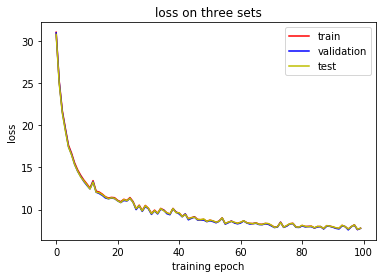

In [6]:
plt.figure(1)
ptr,=plt.plot(range(max_epoch),loss_train_his,'r-')
pva,=plt.plot(range(max_epoch),loss_val_his,'b-')
pte,=plt.plot(range(max_epoch),loss_test_his,'y-')
plt.xlabel('training epoch')
plt.ylabel('loss')
plt.title('loss on three sets')
plt.legend((ptr,pva,pte),('train','validation','test'))
# plt.savefig('model-DRAW.png')
plt.show()

In [7]:
def draw_patch(image,_gx,_gy,_stride,_sigma):
    '''
    draw the attention boundary on the canvas
    width of edge reflects sigma
    '''
    fig = plt.figure(1)
    ax = fig.add_subplot(111, aspect='equal')
    plt.imshow(image,vmin=0,vmax=1,cmap='gray')
    upper_left_x=_gx-_stride*(patch-1)//2
    upper_left_y=_gy-_stride*(patch-1)//2
    width=_stride*(patch-1)
    height=_stride*(patch-1)
    rect = patches.Rectangle((upper_left_x,upper_left_y),width,height,linewidth=_sigma*3.0,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

INFO:tensorflow:Restoring parameters from parameters/DRAW/DRAW.ckpt
time = 0
gx = 16.272207
gy = 12.060698
stride = 1.8425845
sigma = 0.9578153


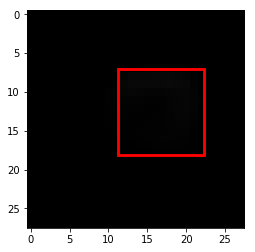

time = 1
gx = 18.312946
gy = 10.779136
stride = 1.5064144
sigma = 1.474413


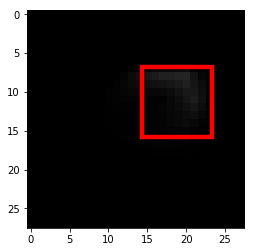

time = 2
gx = 19.083847
gy = 10.357142
stride = 1.2599077
sigma = 1.9916598


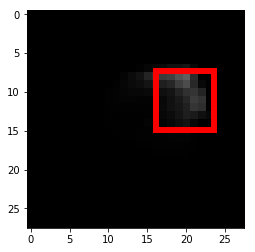

time = 3
gx = 17.89137
gy = 11.197982
stride = 1.4606094
sigma = 1.8287644


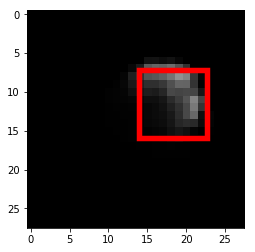

time = 4
gx = 16.767298
gy = 12.080325
stride = 1.6189042
sigma = 1.6443621


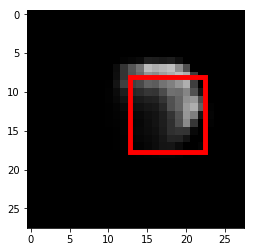

time = 5
gx = 15.780218
gy = 12.903653
stride = 1.7061046
sigma = 1.4940453


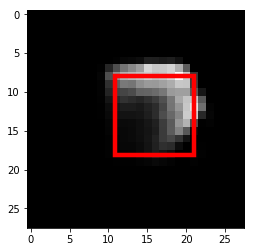

time = 6
gx = 14.928063
gy = 13.766092
stride = 1.744165
sigma = 1.4205725


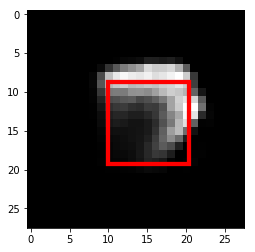

time = 7
gx = 14.102391
gy = 14.749211
stride = 1.7353474
sigma = 1.3989365


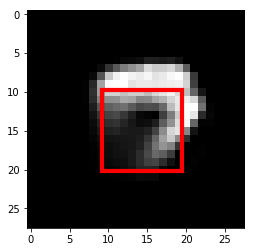

time = 8
gx = 13.270495
gy = 15.817057
stride = 1.7561693
sigma = 1.411804


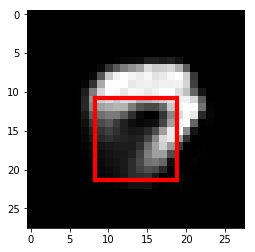

time = 9
gx = 12.389395
gy = 16.827385
stride = 1.704833
sigma = 1.45082


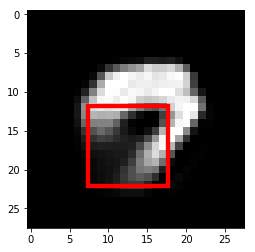

time = 10
gx = 11.635075
gy = 17.9718
stride = 1.663097
sigma = 1.4791523


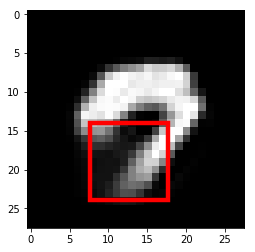

time = 11
gx = 10.854857
gy = 19.019873
stride = 1.5765716
sigma = 1.5107323


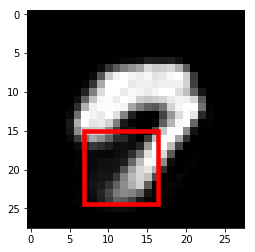

time = 12
gx = 10.0989895
gy = 20.115328
stride = 1.4861465
sigma = 1.5818617


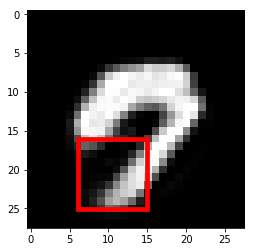

time = 13
gx = 9.44056
gy = 21.343363
stride = 1.3841561
sigma = 1.753924


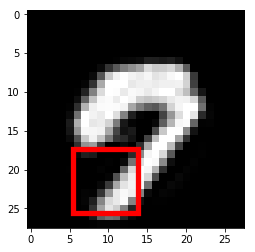

time = 14
gx = 8.878112
gy = 22.5689
stride = 1.1701251
sigma = 2.5014536


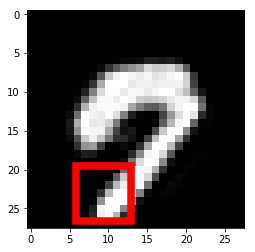

In [10]:
G_batch_size=tf.placeholder(shape=(),dtype=tf.int32,name='batch_size')
G_init_state_decode=decoder_lstm.zero_state(G_batch_size, tf.float32)
G_state_decode=None
G_unit_gaussian=tf.distributions.Normal(loc=tf.zeros((G_batch_size,latent_dim)),scale=tf.ones((G_batch_size,latent_dim)))
G_canvas=tf.zeros(shape=[G_batch_size,channel,height,width],dtype=tf.float32)

G_canvas_his=[]
G_write_paras_his=[]
for t in range(n_glimpse):
    G_Z=G_unit_gaussian.sample()
    with tf.variable_scope("LSTM_decoder") as vs:
        decoder_out,G_state_decode=decoder_lstm(G_Z,G_init_state_decode if t==0 else G_state_decode)
    _gx,_gy,_sigma,_stride,_gamma=decode_attention_para(decoder_out,WRITE_attention_paras)
    G_write_paras_his.append((_gx,_gy,_stride,_sigma))
    new_patch_image=WRITE_patch(decoder_out)
    _FX,_FY=filterbank(G_batch_size,_gx,_gy,_sigma,_stride)
    added_image=write(new_patch_image,G_batch_size,_FX,_FY,_gamma)
    G_canvas+=added_image
    G_canvas_his.append(G_canvas)

saver=tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    saver.restore(sess, "parameters/DRAW/DRAW.ckpt")
    output,paras=sess.run([G_canvas_his,G_write_paras_his],feed_dict={G_batch_size:1})
#     images,labels=mnist.test.next_batch(1)
#     plt.imshow(images.reshape(28,28),vmin=0,vmax=1,cmap='gray')
#     plt.show()
#     output,paras,temp=sess.run([canvas_his,write_paras_his,Z],feed_dict={X:images.reshape(-1,1,28,28)})
#     print(temp)
    for tt in range(n_glimpse):
        print('time =',tt)
        new_img=output[tt].reshape(28,28)
        para=paras[tt]
        print('gx =',para[0][0,0])
        print('gy =',para[1][0,0])
        print('stride =',para[2][0,0])
        print('sigma =',np.sqrt(para[3][0,0]))
#         print(np.min(new_img),np.max(new_img))
#         print(dd)
        draw_patch(new_img,para[0][0,0],para[1][0,0],para[2][0,0],np.sqrt(para[3][0,0]))

In [9]:
# w,b=WRITE_attention_paras.variables

# with tf.Session() as sess:
#     tf.global_variables_initializer().run()
#     saver.restore(sess, "parameters/DRAW/DRAW.ckpt")
#     w_out=sess.run(w)
#     b_out=sess.run(b)
#     print(w_out)